In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from yabox.problems import Levy, BaseProblem

In [2]:
sns.set_style('whitegrid')

# Differential Evolution

## Evolutionary Algorithm
An evolutionary algorithm is an algorithm that uses mechanisms inspired by the theory of evolution, where the fittest individuals of a population are the ones that produce more offspring, which in turn inherit the good traits of the parents. This makes the new generation more likely to survive in the future as well, and so the population improves over time, generation after generation. This is possible due to different mechanisms such as mutation, recombination and selection, among others. 
At each pass through the population the algorithm mutates each candidate solution by mixing with other candidate solutions to create a trial candidate. 

## Differential Evolution
[Great Explanation](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/)

### Main Points
* Black-box optimisation is useful when we don't know the *analytical form* of the optimisation function.  
* DE doesn’t guarantee to obtain the global minimum of a function.
* The difficulty of finding the optimal solution increases *exponentially with the number of dimensions (parameters).*
![complexity](https://pablormier.github.io/assets/img/de/comp_de3000.png)

Differential evolution is a powerful algorithm for black-box optimisation (derivative-free optimisation). It was invented by R. Storn and K. Price in 1997. 

Differential Evolution is a type of evolutionary algorithm where a population of candidate solutions generate offsprings which compete with the rest of the population according to their fitness. *Each candidate is represented by a vector of real numbers which are inputs to the function to minimize.*

The only two mandatory parameters that we need to provide are **fobj** and **bounds**:

>fobj: f(x) function to optimize.

>bounds: a list with the lower and upper bound for each parameter of the function. For example: $bounds_{x}$= [(-5, 5), (-5, 5), (-5, 5), (-5, 5)] means that each variable $x_{I}$, i∈[1,4] is bound to the interval [-5, 5].


When the number of dimensions grows, the number of iterations required by the algorithm to find a good solution grows as well.

### Initialisation
Create a population of `popsize` and `n` dimensions

```python
pop = np.random.rand(popsize, dimensions)
```

### Evaluation
The next step is to apply a linear transformation to convert each component from [0, 1] to [min, max]. Here min, max are the upper & lower bounds. Then we evaluate each candidate using the *fobj* function.

```python
pop_denorm = min_b + pop * diff
for ind in pop_denorm:
	print(ind, fobj(ind))
```

### Recombination
Recombination is about mixing the information of the *mutant* with the information of the *current* vector to create a *trial* vector. This is done by changing the numbers at some positions in the current vector with the ones in the mutant vector. For each position, we decide (with some probability defined by **crossp**) if that number will be replaced or not by the one in the mutant at the same position.

```python
cross_points = np.random.rand(dimensions) < crossp
trial = np.where(cross_points, mutant, pop[j])
```

### Mutation
For each sample in the population, create a mutant vector by -

	1. Randomly select 3 vectors a, b & c
	2. Calculate `mutant = a + mut*(b-c)` where *mut* is the `mutation` factor
	3. Normalize the mutant vector by clipping values greater than 1 to 1 & negative values to 0


### Replacement
Calculate *trial_denorm* by denormalising the *trial* vector and evaluate it. If the *trial* vector is better than the *current* vector then we replace it with the new one.

```python
trial_denorm = min + trial * diff

where, min = lower bound
	     diff = np.fabs(min - max)
```
We then evaluate this new vector with **fobj**. If the trial vector is worse than the target vector, then target vector is preserved otherwise discarded. After this process, some of the original vectors of the population will be replaced by better ones, and after many iterations, the whole population will eventually converge towards the solution.



## Using Numpy

In [3]:
import numpy as np

In [30]:
def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield best, fitness[best_idx]

In [25]:
def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000):
    # creating a population of size popsize with each sample having dimensions=len(bounds)
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)

    # original bounds are (-5,5) but samples are in (0, 1), so denormalizing them back to (-5,5)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    
    # finding the best sample from the population
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    print(len(fitness))
    best_idx = np.argmin(fitness, axis=1)
    print(len(pop_denorm), best_idx)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            # mutation
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            # recombination
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            # replacement
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                # updating the best vector
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield best, fitness[best_idx]

### Square Function

In [12]:
class SquareProblem(BaseProblem):
    def __init__(self, bounds=None):
        super().__init__(bounds=bounds)

    def evaluate(self, x):
        return sum(x**2)/len(x)

In [13]:
problem = SquareProblem(bounds=[(-5, 5)]*2)

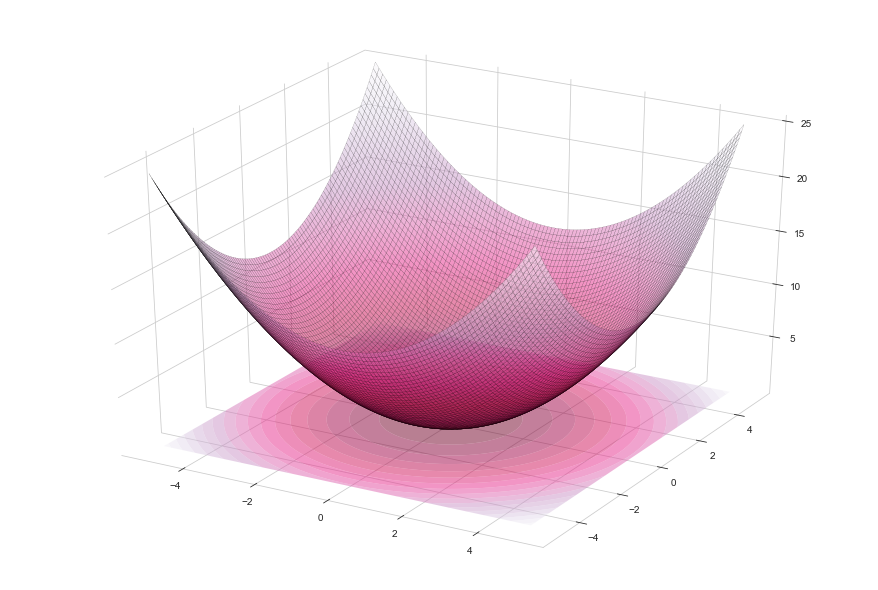

In [14]:
problem.plot3d()

In [42]:
result = list(de(lambda x: x**2, bounds=[(-100, 100)]))

In [43]:
xs, fs = zip(*result)

In [47]:
fs[-1]

array([0.])

## Using Scipy

In [1]:
from scipy.optimize import differential_evolution

### Square Function

In [2]:
fobj = lambda x: sum(x**2)/len(x)
bounds = [(-100, 100)]

In [3]:
result = differential_evolution(fobj, bounds=bounds, strategy='randtobest1bin')

In [4]:
result

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 947
     nit: 62
 success: True
       x: array([0.])

### Ackley Function

In [5]:
def ackley_func(x):
    y = x[1]
    x = x[0]
    term1 = np.sqrt(0.5*(x**2+y**2))
    term2 = 0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))
    term3 = -20*(np.exp(-0.2*term1))
    term4 = -np.exp(term2)
    return term3+term4+np.exp(1)+20

In [51]:
class AckleyProblem(BaseProblem):
    def __init__(self, bounds=None):
        super().__init__(bounds=bounds)

    def evaluate(self, x):
        y = x[1]
        x = x[0]
        term1 = np.sqrt(0.5*(x**2+y**2))
        term2 = 0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))
        term3 = -20*(np.exp(-0.2*term1))
        term4 = -np.exp(term2)
        return term3+term4+np.exp(1)+20

In [52]:
problem = AckleyProblem(bounds=[(-5, 5)]*2)

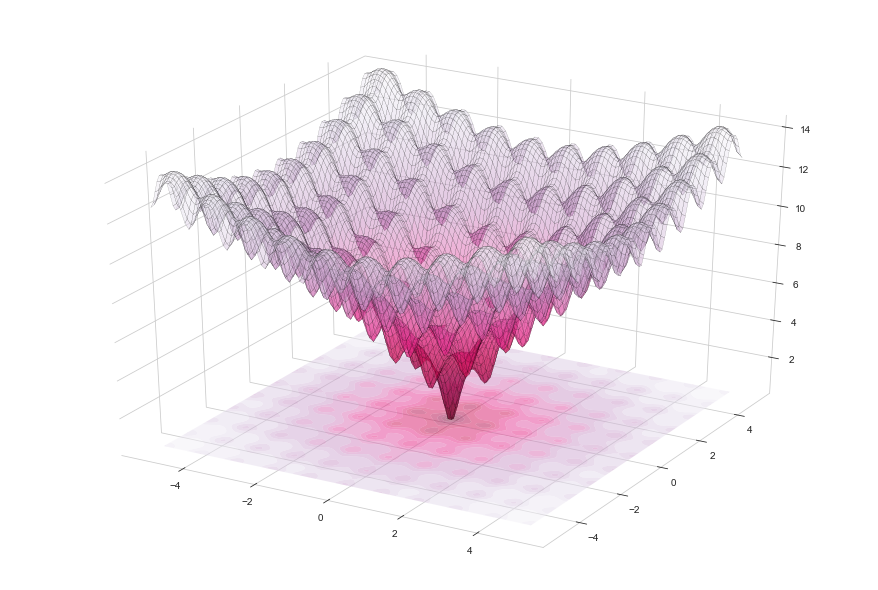

In [53]:
problem.plot3d()

In [10]:
bounds = [(-100, 100)]*2

In [12]:
result = differential_evolution(ackley_func, bounds=bounds, strategy='randtobest1bin')

In [13]:
result

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 3123
     nit: 101
 success: True
       x: array([0., 0.])